# Deep Learning in Practice
## Homework 1 - Problem 1
Elias Masquil

Nicolas Violante

1.   List item
2.   List item



## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [2]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [3]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [4]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [5]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [6]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 9')

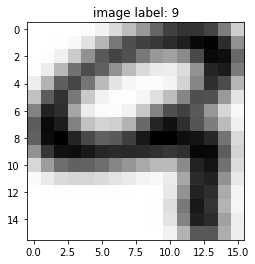

In [7]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

In [8]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h = F.relu(self.l1(inputs))
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

## Train your Model

In [49]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, linear=False, verbose=True, device="cuda"):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model = model.to(device)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            if linear:
                y_pre = model(images.view(batch_size, -1)) 
            else:
                y_pre = model(images)
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

# Calculate the accuracy to evaluate the model
def accuracy(dataset, model, linear=False):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            if linear:
                images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [10]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, linear=True)

Epoch [1/20], Loss: 0.0855
Epoch [2/20], Loss: 0.0724
Epoch [3/20], Loss: 0.0587
Epoch [4/20], Loss: 0.0454
Epoch [5/20], Loss: 0.0343
Epoch [6/20], Loss: 0.0262
Epoch [7/20], Loss: 0.0209
Epoch [8/20], Loss: 0.0176
Epoch [9/20], Loss: 0.0155
Epoch [10/20], Loss: 0.0141
Epoch [11/20], Loss: 0.0129
Epoch [12/20], Loss: 0.0121
Epoch [13/20], Loss: 0.0114
Epoch [14/20], Loss: 0.0109
Epoch [15/20], Loss: 0.0105
Epoch [16/20], Loss: 0.0101
Epoch [17/20], Loss: 0.0097
Epoch [18/20], Loss: 0.0094
Epoch [19/20], Loss: 0.0091
Epoch [20/20], Loss: 0.0089


Text(0.5, 1.0, 'Visualization of convergence')

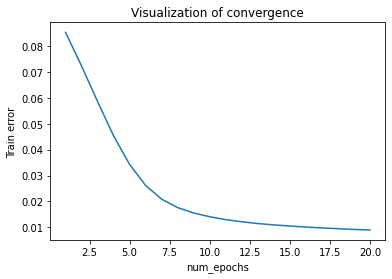

In [11]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [12]:
accuracy(val_set, model, True)

Accuracy of the model : 93.26 %


Text(0.5, 1.0, 'Prediction label: 0')

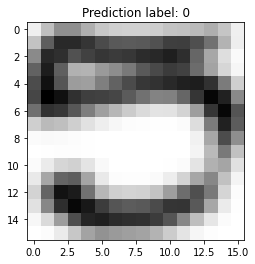

In [15]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

## Custom code for hyper-parameter tunning

In [13]:
class Custom(nn.Module):
    
    def __init__(self, n_layers, kernel_size, activation_fn):
        super(Custom, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(nn.Conv2d(2**i, 2**(i+1), kernel_size))
            self.layers.append(activation_fn)

        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(2**n_layers * (16 - (kernel_size - 1)*n_layers)**2, 10))
        # self.layers.append(activation_fn)
        
    def forward(self, inputs):
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs)
        outputs = F.softmax(outputs, dim=1)# Use softmax as the activation function for the last layer
        return outputs

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [25]:
for n_layers in [1, 2, 3]:
    model = Custom(n_layers, 5, nn.Tanh())
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(20, batch_size, criterion, optimizer, model, train_set, verbose=False)
    accuracy(val_set, model)

Accuracy of the model : 93.65 %
Accuracy of the model : 93.34 %
Accuracy of the model : 93.18 %


### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

In [ ]:
for bs in [10, 100, 1000]:
    for lr in [0.001, 0.01, 0.1, 1, 10]:
        print(f"{bs} {lr}")
        model = Custom(4, 3, nn.ReLU())
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        _ = train(20, bs, criterion, optimizer, model, train_set, verbose=False)
        accuracy(val_set, model)

In [68]:
models = [Custom(4, 3, nn.ReLU()), Custom(4, 3, nn.ReLU())]
evols = []
for i, e in enumerate([75, 100]):
    model = models[i]
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    err = train(e, 10, criterion, optimizer, model, train_set, verbose=True, device="cuda")
    evols.append(err)
    accuracy(val_set, model.to("cpu"))


Epoch [1/75], Loss: 0.0336
Epoch [2/75], Loss: 0.0135
Epoch [3/75], Loss: 0.0089
Epoch [4/75], Loss: 0.0072
Epoch [5/75], Loss: 0.0063
Epoch [6/75], Loss: 0.0053
Epoch [7/75], Loss: 0.0045
Epoch [8/75], Loss: 0.0042
Epoch [9/75], Loss: 0.0039
Epoch [10/75], Loss: 0.0033
Epoch [11/75], Loss: 0.0031
Epoch [12/75], Loss: 0.0029
Epoch [13/75], Loss: 0.0029
Epoch [14/75], Loss: 0.0025
Epoch [15/75], Loss: 0.0021
Epoch [16/75], Loss: 0.0023
Epoch [17/75], Loss: 0.0021
Epoch [18/75], Loss: 0.0019
Epoch [19/75], Loss: 0.0018
Epoch [20/75], Loss: 0.0017
Epoch [21/75], Loss: 0.0015
Epoch [22/75], Loss: 0.0016
Epoch [23/75], Loss: 0.0014
Epoch [24/75], Loss: 0.0013
Epoch [25/75], Loss: 0.0014
Epoch [26/75], Loss: 0.0013
Epoch [27/75], Loss: 0.0010
Epoch [28/75], Loss: 0.0013
Epoch [29/75], Loss: 0.0010
Epoch [30/75], Loss: 0.0012
Epoch [31/75], Loss: 0.0011
Epoch [32/75], Loss: 0.0008
Epoch [33/75], Loss: 0.0007
Epoch [34/75], Loss: 0.0013
Epoch [35/75], Loss: 0.0008
Epoch [36/75], Loss: 0.0008
E

In [57]:
accuracy(val_set, models_good[0].to("cpu"))

Accuracy of the model : 97.44 %


### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [60]:
class Custom2(nn.Module):
    
    def __init__(self, n_layers, kernel_size, activation_fn):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(nn.Conv2d(2**i, 2**(i+1), kernel_size))
            self.layers.append(activation_fn)

        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(2**n_layers * (16 - (kernel_size - 1)*n_layers)**2, 10))
        
    def forward(self, inputs):
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs)
        return outputs

In [69]:
model = Custom2(4, 3, nn.ReLU())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
err = train(75, 10, nn.CrossEntropyLoss(), optimizer, model, train_set, verbose=True, device="cuda")
accuracy(val_set, model.to("cpu"))

Epoch [1/75], Loss: 0.7844
Epoch [2/75], Loss: 0.3287
Epoch [3/75], Loss: 0.2203
Epoch [4/75], Loss: 0.1736
Epoch [5/75], Loss: 0.1407
Epoch [6/75], Loss: 0.1155
Epoch [7/75], Loss: 0.1071
Epoch [8/75], Loss: 0.0842
Epoch [9/75], Loss: 0.0790
Epoch [10/75], Loss: 0.0689
Epoch [11/75], Loss: 0.0660
Epoch [12/75], Loss: 0.0510
Epoch [13/75], Loss: 0.0545
Epoch [14/75], Loss: 0.0465
Epoch [15/75], Loss: 0.0409
Epoch [16/75], Loss: 0.0413
Epoch [17/75], Loss: 0.0384
Epoch [18/75], Loss: 0.0313
Epoch [19/75], Loss: 0.0303
Epoch [20/75], Loss: 0.0307
Epoch [21/75], Loss: 0.0253
Epoch [22/75], Loss: 0.0222
Epoch [23/75], Loss: 0.0188
Epoch [24/75], Loss: 0.0226
Epoch [25/75], Loss: 0.0212
Epoch [26/75], Loss: 0.0181
Epoch [27/75], Loss: 0.0207
Epoch [28/75], Loss: 0.0174
Epoch [29/75], Loss: 0.0127
Epoch [30/75], Loss: 0.0196
Epoch [31/75], Loss: 0.0160
Epoch [32/75], Loss: 0.0130
Epoch [33/75], Loss: 0.0150
Epoch [34/75], Loss: 0.0201
Epoch [35/75], Loss: 0.0065
Epoch [36/75], Loss: 0.0068
E

In [67]:
best = model

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [63]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [64]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [70]:
accuracy(test_set, model)

Accuracy of the model : 94.87 %
